In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/Users/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dtype = torch.float32

In [3]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/Users/scrotti/Aptamer2025py/callback.py'>

## Generate

In [4]:
tr = tree.Tree()
tr.add_node(-1, name = "round 1 with selection")
tr.add_node(0, name = "round 2 with selection")

selected_modes = torch.BoolTensor(
    [[1],
     [1]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == tr.get_n_nodes()
n_rounds = n_selection_rounds + 1

In [5]:
L, q = 5, 2

k_teacher = torch.randn(L, q, dtype=dtype)
h_teacher = torch.randn(L, q, dtype=dtype)
J_teacher = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0_teacher = energy_models.IndepSites(k_teacher)
ps_teacher = selex_distribution.MultiModeDistribution(energy_models.Potts(J_teacher, h_teacher), normalized=False)
model_teacher = selex_distribution.MultiRoundDistribution(Ns0_teacher, ps_teacher, tr, selected_modes)
model_teacher.train(mode=False);

In [6]:
n_chains = 10**4
chains_teacher = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)

In [7]:
t = 0
n_max_sweeps = 50

sampling.compute_mixing_time(model_teacher, t, chains[t], n_max_sweeps)

AttributeError: module 'sampling' has no attribute 'compute_mixing_time'

In [492]:
n_sweeps = 20
energies = model_teacher.sample(chains_teacher, n_sweeps)

## Learn

In [494]:
sequences_oh = chains_teacher
total_reads = total_reads = torch.Tensor([sequences_oh.shape[1] for _ in range(n_rounds)])

In [495]:
k = torch.randn(L, q, dtype=dtype)
h = torch.randn(L, q, dtype=dtype)
J = utils.rand_coupling_matrix(L, q, dtype=dtype, rescaling=1e-4)
# J = torch.zeros(L, q, L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
ps = selex_distribution.MultiModeDistribution(energy_models.Potts(J, h), normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [496]:
batch_size = 10**4
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=torch.device('cpu')) 
                for id in range(n_rounds)]

In [497]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [498]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.TeacherStudentCallback(model_teacher)]

In [499]:
lr = 0.05
weight_decay = 0.0
# optimizer = torch.optim.SGD([
#                             {'params': model.selection.parameters(), 'lr': 10},
#                             {'params': model.round_zero.parameters(), 'lr': lr}
#                         ])
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

In [517]:
n_sweeps = 10
target_pearson = 1
max_epochs = 1000

training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, 
               callbacks=callbacks, log_weights=log_weights,
               optimizer=optimizer)

 0.00%[                             ] Epoch: 0/1000 [00:00, ?it/s]

KeyboardInterrupt: 

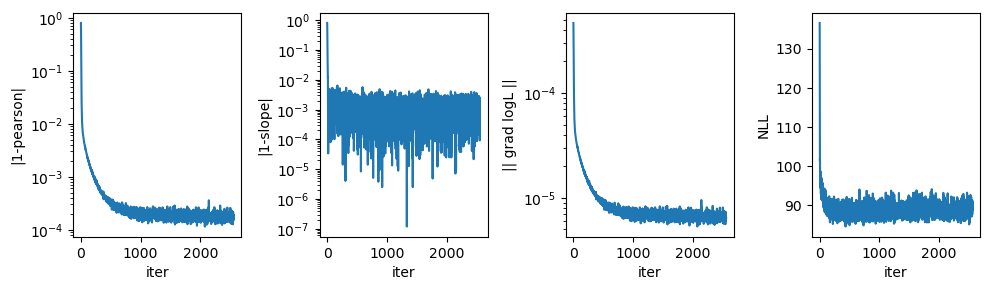

In [518]:
callbacks[0].plot();

POTTS


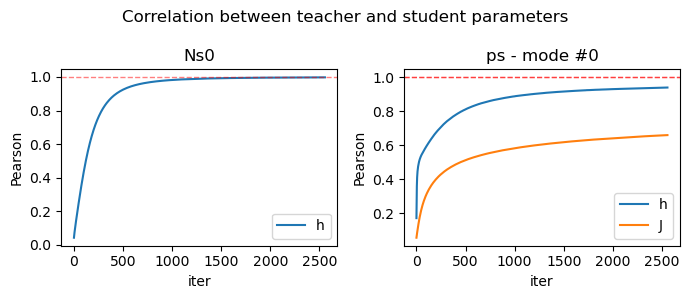

In [521]:
callbacks[1].plot(figsize=(7,3))
print('POTTS')

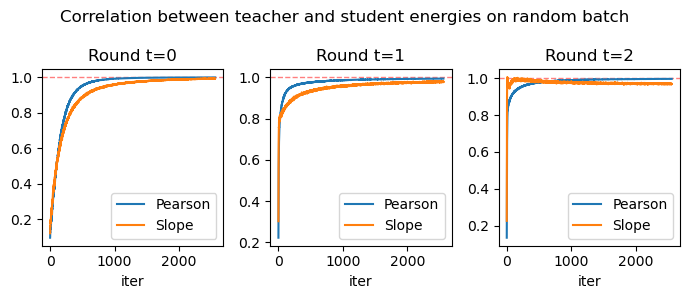

In [522]:
callbacks[1].plot_energies(figsize=(7,3))

0.9973134398460388

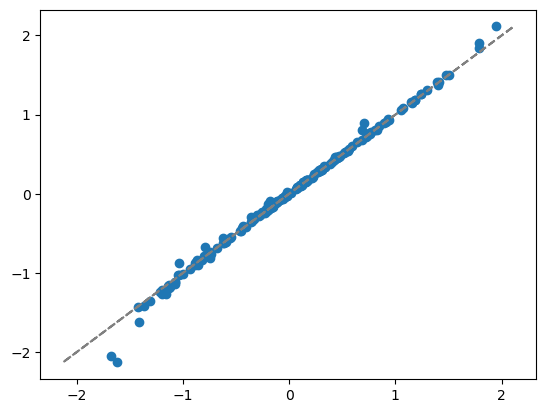

In [523]:
X = model.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
plt.plot(Y, Y,ls='--', color='gray', alpha=1)
plt.scatter(X, Y)
torch.corrcoef(torch.stack([X,Y]))[0,1].item()

0.9400041103363037

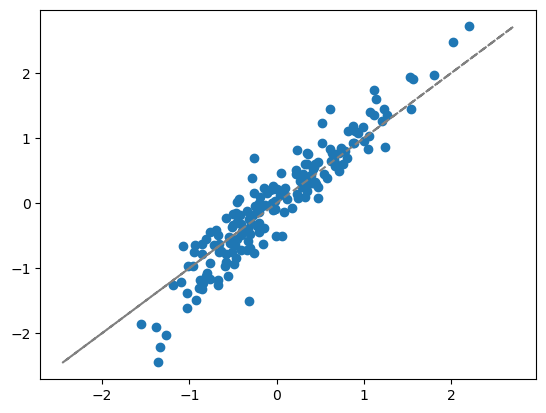

In [524]:
X = model.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
plt.plot(Y, Y,ls='--', color='gray', alpha=1)
plt.scatter(X, Y)
torch.corrcoef(torch.stack([X,Y]))[0,1].item()

0.659606397151947

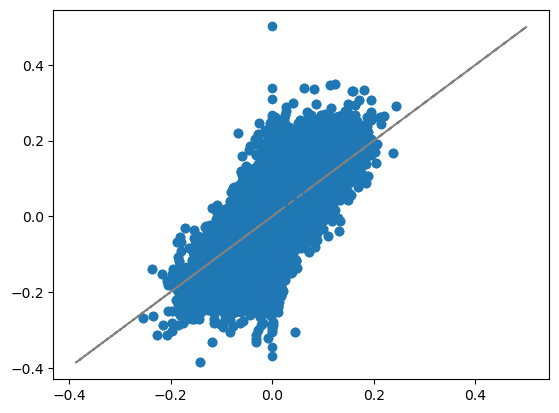

In [525]:
X = model.selection.modes[0].set_zerosum_gauge().J.detach().reshape(-1)
Y = model_teacher.selection.modes[0].set_zerosum_gauge().J.detach().reshape(-1)
plt.plot(Y, Y,ls='--', color='gray', alpha=1)
plt.scatter(X, Y)
torch.corrcoef(torch.stack([X,Y]))[0,1].item()

In [526]:
n_sweeps = 20
n_chains = 10**5
chains_student = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
_ = model.sample(chains_student, n_sweeps)

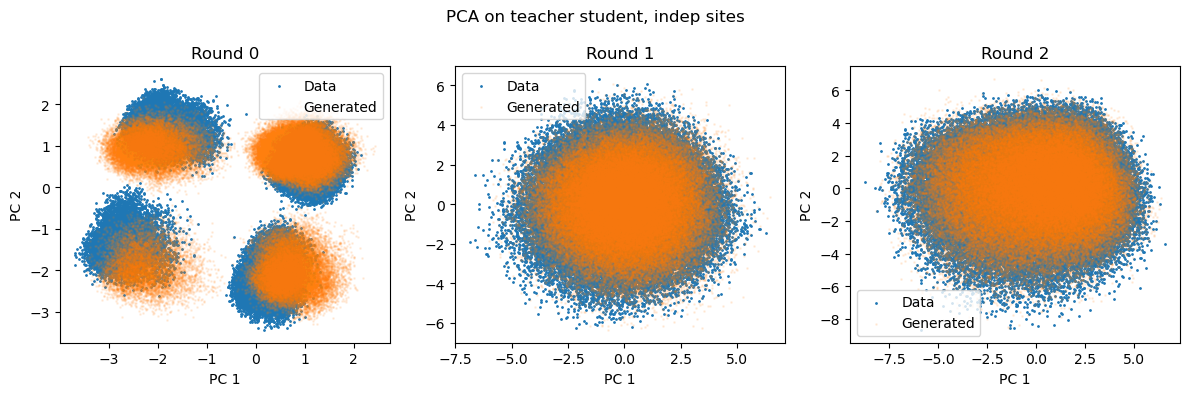

In [534]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
markersize = 1
for t in range(n_rounds):
    pcs_gen, pcs_data = utils.compute_pca(chains_student[t], sequences_oh[t])
    ax = axes[t]
    ax.scatter(pcs_data[:,0], pcs_data[:,1], label='Data', s=markersize)
    ax.scatter(pcs_gen[:,0], pcs_gen[:,1], label='Generated', s=markersize, alpha=0.1)
    ax.set_xlabel('PC 1'); ax.set_ylabel('PC 2')
    ax.set_title(f'Round {t}')
    ax.legend()
fig.suptitle('PCA on teacher student, indep sites')
fig.tight_layout()

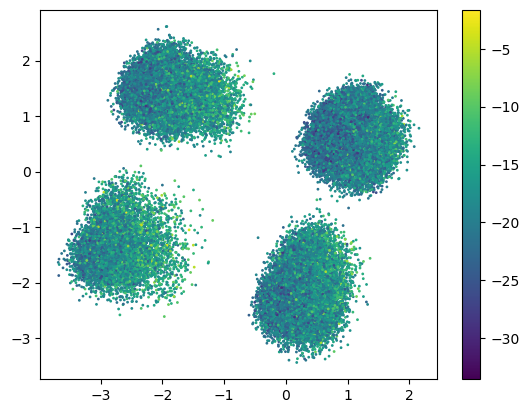

In [533]:
t = 0
pcs, _ = utils.compute_pca(sequences_oh[t], chains_student[t])
energies = model_teacher.compute_energy_up_to_round(sequences_oh[t], t).detach()
plt.scatter(pcs[:,0], pcs[:,1], label='Data', s=markersize, c=energies)
plt.colorbar()